In [90]:
import numpy as np
import scipy.integrate 
import matplotlib.pyplot as plt
import matplotlib.colors 
import tqdm
import scipy.signal
import statsmodels.tsa.stattools

In [91]:
#define time interval, T should be integer
T = 10000

def mu(t):
    return 2/T * t - 1

def f(x,t): 
    return (x - x**3 /3.0 - mu(t))

In [6]:
def get_equilibria_paths():
    n = T + 1
    ts = np.linspace(0,T,n)
    upper = np.zeros(n)
    lower = np.zeros(n)
    unstable = np.zeros(n)

    for i in tqdm.trange(n):
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,ts[i]),(0.0,50),[2.0], method="BDF")
        upper[i] = sol.y[0,-1]
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,ts[i]),(0.0,50),[-2.0], method="BDF")
        lower[i] = sol.y[0,-1]
        sol = scipy.integrate.solve_ivp(lambda t,x: -f(x,ts[i]),(0.0,50),[0.0], method="BDF")
        unstable[i] = sol.y[0,-1]
     
    unstable[np.abs(unstable)>1] = np.nan

    return ts,upper,lower,unstable


In [92]:
ts,upper,lower,unstable = get_equilibria_paths()

100%|██████████| 10001/10001 [10:49<00:00, 15.39it/s]


In [119]:
#numerical simulation of SDEs:

steps_per_unit_time = 10                                           
solve_ts = np.linspace(0,T,T*steps_per_unit_time + 1)
dt = 1/steps_per_unit_time



#white noise case

xs_white = np.zeros(T*steps_per_unit_time + 1)
# xs_white[0] = 2.103803356099623
xs_white[0] = 2.07

sigma = 0.01
white_noise = np.random.normal(0,np.sqrt(dt),T*steps_per_unit_time + 1)


for i in tqdm.trange(T*steps_per_unit_time):
    xs_white[i+1] = xs_white[i] + f(xs_white[i],solve_ts[i])*dt + sigma*white_noise[i]


# wiener = np.zeros(T*steps_per_unit_time + 1)
# wiener[0] = 2.07
# for i in tqdm.trange(T*steps_per_unit_time):
#     wiener[i+1] = wiener[i] + sigma*white_noise[i]


#red noise case

xs_red = np.zeros(T*steps_per_unit_time+1)
xs_red[0] = 2.103803356099623                                                           #upper[0]
kappa = 0.05                                                                    #shouldn't be too small 

def eta(theta):
    eta = np.zeros(T*steps_per_unit_time + 1)
    for i in tqdm.trange(T*steps_per_unit_time - 1):
        eta[i+1] = np.exp(-theta*dt)*eta[i] + np.sqrt(1/(2*theta)*(1-np.exp(-2*theta*dt)))*np.random.normal(0,1)
    return eta

eta = eta(1)


for i in tqdm.trange(T*steps_per_unit_time):
    xs_red[i+1] = xs_red[i] + f(xs_red[i],solve_ts[i])*dt + kappa*eta[i]*dt



xs_white_filtered = xs_white[::steps_per_unit_time]
xs_red_filtered = xs_red[::steps_per_unit_time]

white_noise_filtered = white_noise[::steps_per_unit_time]
eta_filtered = eta[::steps_per_unit_time]


100%|██████████| 100000/100000 [00:00<00:00, 547231.36it/s]


In [94]:
#version with var and ar over several time units

window_length = 200 

def get_var(x):
    #get var of T-windows with length window length. Gives n_windows values
    n_windows = int(T/window_length) 
    var = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        var[i] = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2).var()
    return var


def get_ar(x):
#x should have size T*steps_per_unit_time + 1
    n_windows = int(T/window_length) 
    ar = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        ar[i] = statsmodels.tsa.stattools.acf(statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2))[1]
    return ar


In [102]:

def get_lambdas(x,noise,method="ratio"):
    
    def fitfunction(f,ls):
        return 1/((2*np.pi*f)**2  + ls**2)          #omega = 2*pi*f ? why not 1 in nominator # vorher: (1/dt)**2
    
    
    n_windows = int(T/window_length) 
    ls = np.full(n_windows,np.nan)
    
    for i in tqdm.trange(n_windows):
        detx = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2)
        f,Sxx = scipy.signal.welch(detx)                                                           #was ist hier der frequency domain?
        f,Sff = scipy.signal.welch(noise[i*window_length:(i+1)*window_length])  #,detrend="linear")
            
        if method == "ratio":
            popt = scipy.optimize.curve_fit(fitfunction,
                                                  f[1:], 
                                                  Sxx[1:]/Sff[1:],
                                                  p0=[1.0],
                                                  bounds=(0.0, np.inf))[0]
            ls[i] = popt[0]
    
    return ls

In [120]:
#version with var and ar over several time units

variance_series_white = get_var(xs_white_filtered)
variance_series_red = get_var(xs_red_filtered)
ac_series_white = get_ar(xs_white_filtered)
ac_series_red = get_ar(xs_red_filtered)

100%|██████████| 50/50 [00:00<00:00, 4397.65it/s]


In [121]:
ls_white = get_lambdas(xs_white_filtered,white_noise_filtered)
ls_red = get_lambdas(xs_red_filtered,eta_filtered)

true_ls = 1 - upper**2

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\mdichgan\AppData\Local\miniconda3\envs\bachelor_thesis\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
100%|██████████| 50/50 [00:00<00:00, 208.25it/s]


In [117]:
true_ls[9300:9350]

array([-3.25129359, -3.25154726, -3.25180109, -3.25205454, -3.25230807,
       -3.25256017, -3.25281522, -3.25306877, -3.2533225 , -3.25357596,
       -3.25382957, -3.25408302, -3.25429535, -3.25458289, -3.25484659,
       -3.25510267, -3.25534952, -3.25560402, -3.25585747, -3.25615576,
       -3.25636424, -3.25661766, -3.25681604, -3.25706629, -3.25737811,
       -3.25763148, -3.25788465, -3.258138  , -3.25840686, -3.25862774,
       -3.25887734, -3.25914982, -3.25940456, -3.25965788, -3.25991123,
       -3.26016437, -3.26041757, -3.26067694, -3.26092393, -3.26115655,
       -3.26143034, -3.26168354, -3.2619367 , -3.26218985, -3.26244312,
       -3.26269624, -3.26299269, -3.26324479, -3.26345533, -3.26370841])

Text(0.5, 0, 'mu')

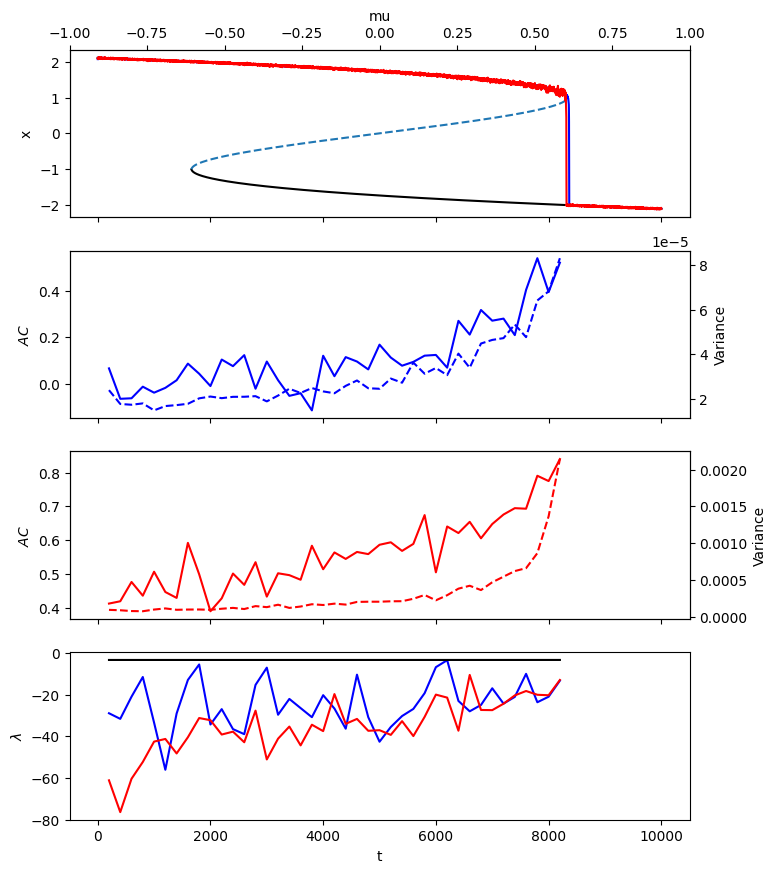

In [124]:
#why is lambda estimation so far from true lambda?, how to choose fs in ls method?


tipp_upper = np.argmin(upper>1)
tipp_lower = np.argmin(lower>-1)


tip_white = np.argmin(xs_white_filtered>1.0)
tip_red = np.argmin(xs_red_filtered>1.0)  


fig,axs = plt.subplots(nrows=4,ncols=1,sharex=True,figsize=(8,10)) 

axs[0].plot(ts[:tipp_upper],upper[:tipp_upper],color = "black")
axs[0].plot(ts[tipp_lower:],lower[tipp_lower:],color = "black")
axs[0].plot(ts[~np.isnan(unstable)],unstable[~np.isnan(unstable)],linestyle = "--")
axs[0].plot(ts,xs_white_filtered,color="blue")
axs[0].plot(ts,xs_red_filtered,color="red")


axs[1].plot(ts[window_length:tip_white:window_length],ac_series_white[:int(tip_white/window_length)],color="blue")                               
ax1_var = axs[1].twinx()
ax1_var.plot(ts[window_length:tip_white:window_length],variance_series_white[:int(tip_white/window_length)],color="blue",linestyle="--")


axs[2].plot(ts[window_length:tip_red:window_length],ac_series_red[:int(tip_red/window_length)],color="red")
ax2_var = axs[2].twinx()
ax2_var.plot(ts[window_length:tip_red:window_length],variance_series_red[:int(tip_red/window_length)],color="red",linestyle="--")


axs[0].set_ylabel("x")
axs[1].set_ylabel(r"$AC$")
axs[2].set_ylabel(r"$AC$")
ax1_var.set_ylabel(r"Variance")
ax2_var.set_ylabel(r"Variance")



axs[3].set_xlabel("t")    
axs[3].plot(ts[window_length:tip_white:window_length],-ls_white[:int(tip_white/window_length)],color="blue")
axs[3].plot(ts[window_length:tip_red:window_length],-ls_red[:int(tip_red/window_length)],color="red")
axs[3].plot(ts[window_length:tipp_upper:window_length],true_ls[:int(tipp_upper/window_length)],color="black")
axs[3].set_ylabel(r"$\lambda$")


ax_0 = axs[0].twiny()
ax_0.set_xlim(-1,1)
ax_0.set_xlabel("mu")

In [135]:
#test if ls method better if computed on small windows


def get_lambdas(x,eta,method="ratio"):
    
    def fitfunction(f,ls):
        return 1/((2*np.pi*f)**2  + ls**2)          #omega = 2*pi*f ? why not 1 in nominator # vorher: (1/dt)**2
    
    
    ls = np.full(T+1,np.nan)
    
    for i in tqdm.trange(T):
        detx = statsmodels.tsa.tsatools.detrend(x[i*steps_per_unit_time:(i+1)*steps_per_unit_time],order=2)
        f,Sxx = scipy.signal.welch(detx)                                    #was ist hier der frequency domain?
        f,Sff = scipy.signal.welch(eta[i*steps_per_unit_time:(i+1)*steps_per_unit_time])  #,detrend="linear")
            
        if method == "ratio":
            popt = scipy.optimize.curve_fit(fitfunction,
                                                  f[1:], 
                                                  Sxx[1:]/Sff[1:],
                                                  p0=[1.0],
                                                  bounds=(0.0, np.inf))[0]
            ls[i+1] = popt[0]
    
    return ls

In [142]:
def get_lambdas1(x,eta,T,method = "ratio"):

    def fitfunction(f,ls):
        return 1/((2*np.pi*f)**2  + ls**2)          #omega = 2*pi*f ? why not 1 in nominator # vorher: (1/dt)**2
    
    
    ls = np.full(T+1,np.nan)
    
    for i in tqdm.trange(T):
        detx = statsmodels.tsa.tsatools.detrend(x[i*steps_per_unit_time:(i+1)*steps_per_unit_time],order=2)
        f,Sxx = scipy.signal.welch(detx,fs=steps_per_unit_time)                                    #was ist hier der frequency domain?
        f,Sff = scipy.signal.welch(eta[i*steps_per_unit_time:(i+1)*steps_per_unit_time],fs = steps_per_unit_time)  #,detrend="linear")
            
        if method == "ratio":
            popt = scipy.optimize.curve_fit(fitfunction,
                                                  f[1:], 
                                                  Sxx[1:]/Sff[1:],
                                                  p0=[1.0],
                                                  bounds=(0.0, np.inf))[0]
            ls[i+1] = popt[0]
    
    return ls

In [143]:
ls_white_unf1 = get_lambdas1(xs_white,white_noise,1000)
ls_red_unf1 = get_lambdas1(xs_red,eta,1000)

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\mdichgan\AppData\Local\miniconda3\envs\bachelor_thesis\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 10, using nperseg = 10
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
100%|██████████| 1000/1000 [00:04<00:00, 206.03it/s]


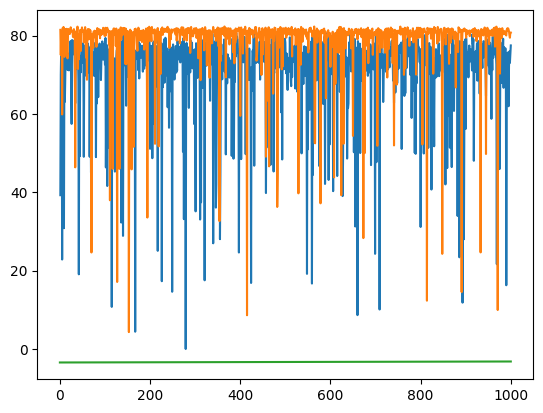

In [144]:
T1 = 1000
plt.plot(np.arange(T1 + 1),ls_white_unf1)
plt.plot(np.arange(T1 + 1),ls_red_unf1)
plt.plot(np.arange(T1 + 1),true_ls[:1001])


In [136]:
ls_white_unf = get_lambdas(xs_white,white_noise)
ls_red_unf = get_lambdas(xs_red,eta)

true_ls = 1 - upper**2

100%|██████████| 10000/10000 [01:27<00:00, 114.27it/s]


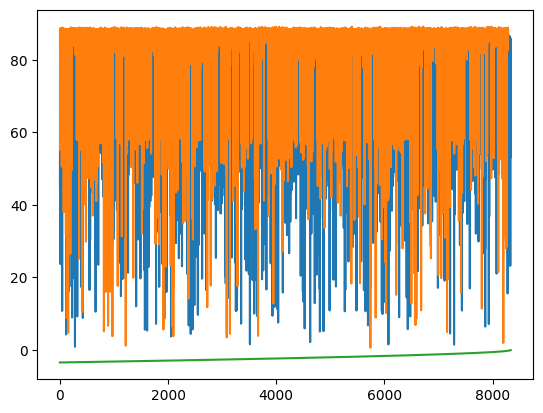

In [139]:
plt.plot(ts[:tip_white],ls_white_unf[:tip_white])
plt.plot(ts[:tip_red],ls_red_unf[:tip_red])
plt.plot(ts[:tipp_upper],true_ls[:tipp_upper])

In [ ]:
#false negatives

In [ ]:
#false postives

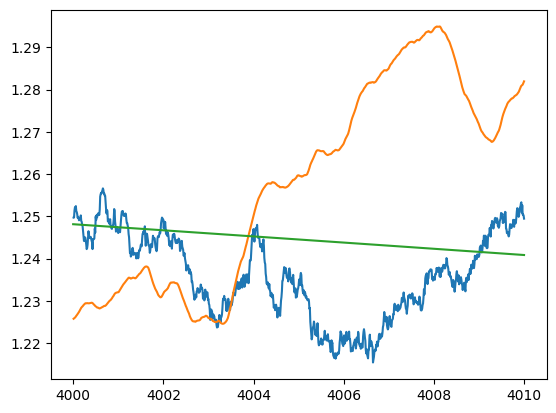

In [47]:
#all steps from unit time i to unit time j
start_t = 4000
stop_t = 4010

n_steps = (stop_t - start_t)*steps_per_unit_time

plt.plot(np.linspace(start_t + dt,stop_t,n_steps),xs_white[start_t*steps_per_unit_time + 1:stop_t*steps_per_unit_time + 1])

plt.plot(np.linspace(start_t + dt,stop_t,n_steps),xs_red[start_t*steps_per_unit_time + 1:stop_t*steps_per_unit_time + 1])

plt.plot(ts[start_t:stop_t + 1],upper[start_t:stop_t + 1])


0.893709367882346

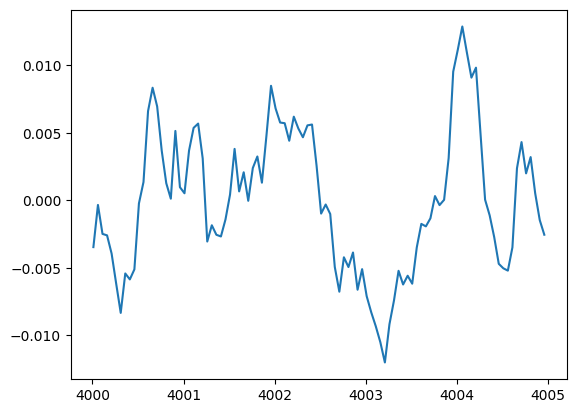

In [76]:
start_t = 4000
stop_t = 4005

x_detrend = statsmodels.tsa.tsatools.detrend(xs_white[start_t*steps_per_unit_time + 1:stop_t*steps_per_unit_time + 1],order=2)
acf = statsmodels.tsa.stattools.acf(statsmodels.tsa.tsatools.detrend(xs_white[start_t*steps_per_unit_time + 1:stop_t*steps_per_unit_time + 1][::5],order=2))[1]
plt.plot(np.linspace(start_t + dt,stop_t,n_steps)[::5],x_detrend[::5])
acf

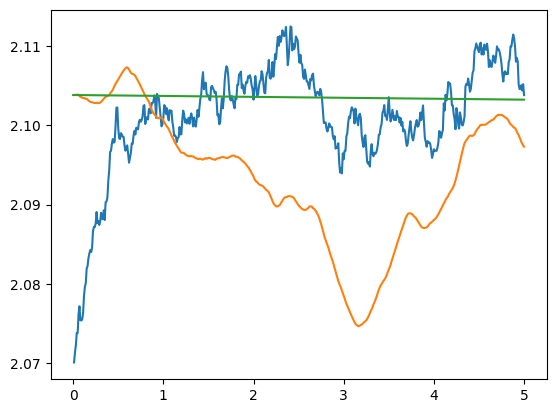

In [62]:
#all steps from unit time i to unit time j
start_t = 0
stop_t = 5

n_steps = (stop_t - start_t)*steps_per_unit_time

plt.plot(np.linspace(start_t + dt,stop_t,n_steps),xs_white[start_t*steps_per_unit_time + 1:stop_t*steps_per_unit_time + 1])

plt.plot(np.linspace(start_t + dt,stop_t,n_steps),xs_red[start_t*steps_per_unit_time + 1:stop_t*steps_per_unit_time + 1])

plt.plot(ts[start_t:stop_t + 1],upper[start_t:stop_t + 1])


0.8592389505688793

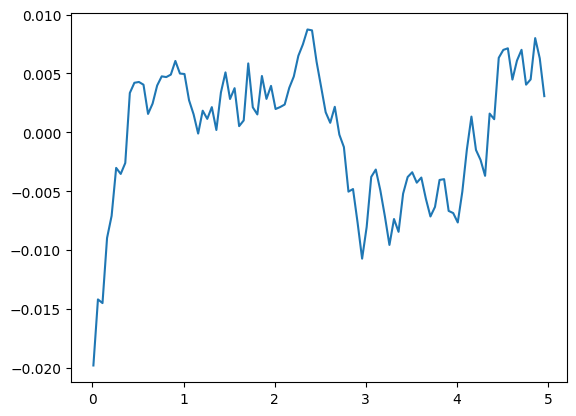

In [77]:
start_t = 0
stop_t = 5

x_detrend = statsmodels.tsa.tsatools.detrend(xs_white[start_t*steps_per_unit_time + 1:stop_t*steps_per_unit_time + 1],order=2)
acf = statsmodels.tsa.stattools.acf(statsmodels.tsa.tsatools.detrend(xs_white[start_t*steps_per_unit_time + 1:stop_t*steps_per_unit_time + 1][::5],order=2))[1]
plt.plot(np.linspace(start_t + dt,stop_t,n_steps)[::5],x_detrend[::5])
acf

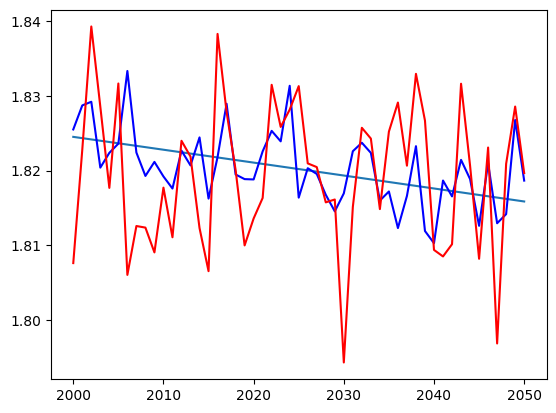

In [50]:
#filtered time series
start_t = 2000
stop_t = 2050

plt.plot(np.arange(start_t,stop_t + 1),upper[start_t:stop_t + 1])
plt.plot(np.arange(start_t,stop_t + 1),xs_white_filtered[start_t:stop_t + 1],color = "blue")
plt.plot(np.arange(start_t,stop_t + 1),xs_red_filtered[start_t:stop_t + 1], color = "red")

0.05280819385658102

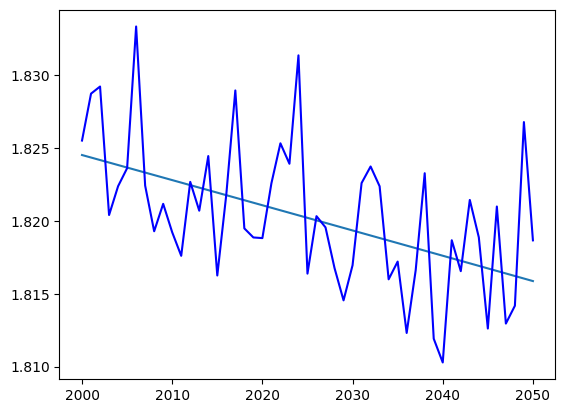

In [69]:
start_t = 2000
stop_t = 2050


plt.plot(np.arange(start_t,stop_t + 1),upper[start_t:stop_t + 1])
plt.plot(np.arange(start_t,stop_t + 1),xs_white_filtered[start_t:stop_t + 1],color = "blue")

acf = statsmodels.tsa.stattools.acf(statsmodels.tsa.tsatools.detrend(xs_white_filtered[start_t:stop_t + 1],order=2))[1]
acf